## Predicting Y-frequencies from X-frequencies of a double pendulum 
### XGBoost achieved 95% MSE but could we do better by tuning/searching hyper-parameters?

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.multioutput import MultiOutputRegressor

from xgboost import XGBRegressor

import chocolate as choco

import pandas as pd

from chocolate import SQLiteConnection

In [2]:
#load saved dataset rather than generating your own
dataset_X_frequencies = np.loadtxt("dataset_X_frequencies.csv",delimiter=',')
dataset_Y_frequencies = np.loadtxt("dataset_Y_frequencies.csv",delimiter=',')
print("generated X frequency bins with shape =",dataset_X_frequencies.shape)#print("generated Y (w1,w2,l1,l2) with shape =",dataset_Y_frequencies.shape)

generated X frequency bins with shape = (1000, 200)


In [34]:
#XGBoost is kinda slow - let's just look at the first 20 bins (0-1Hz)
X_train, X_test, Y_train, Y_test = train_test_split(dataset_X_frequencies[:,100:120], dataset_Y_frequencies[:,100:120], test_size=0.10,random_state=42)

#scale
x_scaler_nl = StandardScaler()
X_train_scaled_nl = x_scaler_nl.fit_transform(X_train)
X_test_scaled_nl = x_scaler_nl.transform(X_test)

y_scaler_nl = StandardScaler().fit(Y_train)
Y_train_scaled_nl = y_scaler_nl.transform(Y_train)
Y_test_scaled_nl = y_scaler_nl.transform(Y_test)

In [3]:
#defin function to build a model with some hyper-parameters fixed and others free to change

def build_XGBRegressor(params):   
    return MultiOutputRegressor(XGBRegressor(n_estimators=int(params['n_estimators']),
                                       learning_rate=params['learning_rate'],
                                        gamma=0, 
                                        subsample=0.75,
                                        colsample_bytree=1,
                                        max_depth=int(params['max_depth'])
                                        ))

In [4]:
#build a function to create a model with arbitrary params, train, fit, test and return a score

def _score(X_train, X_test, Y_train, Y_test, y_scaler_nl, params):
    
    #create ML model
    model = build_XGBRegressor(params)
    
    #train
    model.fit(X_train_scaled_nl, Y_train_scaled_nl)
    
    #predict
    Y_test_pred_scaled = model.predict(X_test_scaled_nl)
    
    #de-scale
    Y_test_pred_unscaled = y_scaler_nl.inverse_transform(Y_test_pred_scaled)

    # Chocolate minimizes the loss
    return mean_squared_error(Y_test_pred_unscaled, Y_test)

In [5]:
def main(X_train, X_test, Y_train, Y_test, y_scaler_nl,run):

    # CREATE and Connect to sqlite database in current directory
    conn = choco.SQLiteConnection(url="sqlite:///"+run+".db")
    
    #search space
    space = {
          "n_estimators":choco.quantized_uniform(50,500,50),
          "learning_rate":choco.quantized_uniform(0.01,1.0,0.01),
          "max_depth":choco.quantized_uniform(3,20,1)
    }
    
    #repeat each model run three times and take average
    cv = choco.Repeat(repetitions=3, reduce=np.mean, rep_col="_repetition_id")
    
    #search strategy - Bayes attempts to "learn" patterns from ALL previous runs
    sampler = choco.Bayes(conn, space, clear_db=True, crossvalidation=cv)
    
    #lets run 10 times and see what if we get a better answer
    for i in range(0,10):
        #examine db and pick next experiment
        token, params = sampler.next()
        #run experiment
        loss = _score(X_train, X_test, Y_train, Y_test, y_scaler_nl, params)
        #print("finished iteration",str(i),"loss",str(loss))
        #add new result to database
        sampler.update(token, loss)

In [46]:
main(X_train, X_test, Y_train, Y_test, y_scaler_nl,"first_try_10_XGBoost")

In [47]:
conn = SQLiteConnection("sqlite:///first_try_10_XGBoost.db")
results = conn.results_as_dataframe()
results.groupby(['id']).mean().sort_values("_loss")

,_loss,learning_rate,max_depth,n_estimators
id,,,,
1,0.000002,0.58,6,350
4,0.000006,0.17,15,100
7,0.000006,0.14,13,350
2,0.000006,0.05,6,100
5,0.000007,0.29,12,300
8,0.000008,0.44,16,450
10,0.000008,0.47,10,100
3,0.000011,0.79,18,250
6,0.000012,0.84,18,250


In [67]:
best_params = {}
loss,best_params['learning_rate'],best_params['max_depth'],best_params['n_estimators']= results.groupby(['id']).mean().sort_values("_loss").iloc[0]

In [70]:
best_xgboost = build_XGBRegressor(best_params)
best_xgboost.fit(X_train_scaled_nl, Y_train_scaled_nl)
Y_test_pred_scaled = best_xgboost.predict(X_test_scaled_nl)
Y_test_pred_unscaled = y_scaler_nl.inverse_transform(Y_test_pred_scaled)
mean_squared_error(Y_test_pred_unscaled, Y_test)

8.581231342712627e-06

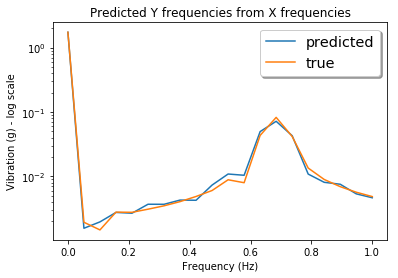

In [75]:
#random_pick = 4 #bad one
#random_pick = 5 #good one
random_pick = 11 #good one


sampling_rate = 10 #samples per time tic, higher=smoother, but will take longer

T = 1/sampling_rate # inverse of the sampling rate
frequencies = np.linspace(0.0, 1.0, 20)
plt.plot(frequencies, Y_test_pred_unscaled[random_pick],label='predicted')
plt.plot(frequencies, Y_test[random_pick],label='true')

plt.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Vibration (g) - log scale')
plt.yscale('log')
plt.title('Predicted Y frequencies from X frequencies');

## Supose we want to get all 40 frequency bins - that is going to be slow

### So let's run training in parallel

In [5]:
#XGBoost is kinda slow - but let's go ahead and get all 100 bins
X_train, X_test, Y_train, Y_test = train_test_split(dataset_X_frequencies[:,100:140], dataset_Y_frequencies[:,100:140], test_size=0.10,random_state=42)

#scale
x_scaler_nl = StandardScaler()
X_train_scaled_nl = x_scaler_nl.fit_transform(X_train)
X_test_scaled_nl = x_scaler_nl.transform(X_test)

y_scaler_nl = StandardScaler().fit(Y_train)
Y_train_scaled_nl = y_scaler_nl.transform(Y_train)
Y_test_scaled_nl = y_scaler_nl.transform(Y_test)

In [6]:
def main(X_train, X_test, Y_train, Y_test, y_scaler_nl,run):

    # CREATE and Connect to sqlite database in current directory
    conn = choco.SQLiteConnection(url="sqlite:///"+run+".db")
    
    #search space
    space = {
          "n_estimators":choco.quantized_uniform(50,500,50),
          "learning_rate":choco.quantized_uniform(0.01,1.0,0.01),
          "max_depth":choco.quantized_uniform(3,20,1)
    }
    
    #repeat each model run three times and take average
    cv = choco.Repeat(repetitions=3, reduce=np.mean, rep_col="_repetition_id")
    
    #search strategy - Bayes attempts to "learn" patterns from ALL previous runs
    sampler = choco.Bayes(conn, space, clear_db=True, crossvalidation=cv)
    
    #lets run 10 times and see what if we get a better answer
    for i in range(0,3):  #<--- fewer inferences per core
        #examine db and pick next experiment
        token, params = sampler.next()
        #run experiment
        loss = _score(X_train, X_test, Y_train, Y_test, y_scaler_nl, params)
        #print("finished iteration",str(i),"loss",str(loss))
        #add new result to database
        sampler.update(token, loss)

In [7]:
from joblib import Parallel, delayed

Parallel(n_jobs=6)(delayed(main)(X_train, X_test, Y_train, Y_test, y_scaler_nl,"second_try_XGBoost") for i in range(6))

[None, None, None, None, None, None]